ML Project: Matrix Completion Outline
------
1. load libraries and data (both movielens and netflix datasets)
2. preprocess both datasets - prepare for training, test, validation
    - this includes breaking down the fields, converting user-item
    interaction data into CSR sparse matrices, batching
3. define autoencoder architecture + include appropriate regularization
4. train model (with regularized costf), monitor loss over epochs
5. k fold validation to tune hyperparameters, test model performance
6. validate model, evaluation
7. visualize results: for a given userID, output users best rated movies + generated recommendations based on trained model



Load Movielens dataset
---

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt


max movie id:  59047 , max user id:  162541
Train Loader - First batch info:
Batch shape: torch.Size([64, 59047])
Batch type: torch.float32
Number of samples in batch: 64
Validation Loader - First batch info:
Batch shape: torch.Size([64, 59047])
Batch type: torch.float32
Number of samples in batch: 64
Test Loader - First batch info:
Batch shape: torch.Size([64, 59047])
Batch type: torch.float32
Number of samples in batch: 64


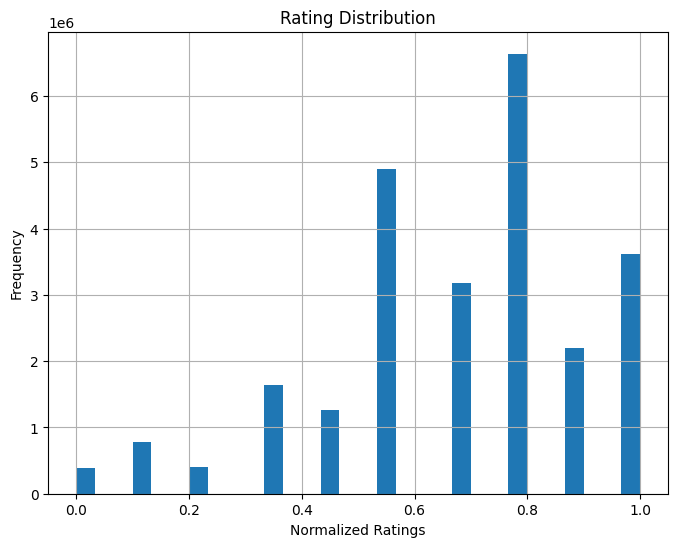

User 144169's Ratings:
Toy Story (1995): 4.50
When Night Is Falling (1995): 4.00
White Balloon, The (Badkonake sefid) (1995): 4.50
Once Upon a Time... When We Were Colored (1995): 4.50
Headless Body in Topless Bar (1995): 4.50
Down Periscope (1996): 4.50
Crimson Tide (1995): 3.50
Three Wishes (1995): 4.00
Ladybird Ladybird (1994): 4.50
Miracle on 34th Street (1994): 5.00
Picture Bride (Bijo photo) (1994): 4.50
Sirens (1994): 3.50
Aristocats, The (1970): 4.00
Family Thing, A (1996): 4.00
Underground (1995): 4.00
Sunset Park (1996): 3.50
Of Love and Shadows (1994): 5.00
Honey Moon (Honigmond) (1996): 4.50
Maya Lin: A Strong Clear Vision (1994): 3.50
Last of the High Kings, The (a.k.a. Summer Fling) (1996): 4.50
Touki Bouki (1973): 4.00
Somebody to Love (1994): 4.50
Frighteners, The (1996): 4.00
She's the One (1996): 3.00
Maybe, Maybe Not (Bewegte Mann, Der) (1994): 4.00
My Favorite Year (1982): 4.00
All About Eve (1950): 3.50
Three Caballeros, The (1945): 5.00
Drop Dead Fred (1991): 4.00

In [50]:
# load the datasets
ratings_data = pd.read_csv('ratings.csv', usecols=['userId', 'movieId', 'rating'])
movies_data = pd.read_csv('movies.csv', usecols=['movieId', 'title', 'genres'])
#ratings_data is a (25000095, 3) (rows, columns) dataframe (all the reviws)
#movies_data is a (62423, 3) (rows, columns) (list of all movies)

# select top users and movies
# (at least for the beginning, so training doesn't take an eternity)
#popularity_threshold = 50 
#top_users = 1000  

#movie_popularity = ratings_data['movieId'].value_counts()
#popular_movies = movie_popularity[movie_popularity >= popularity_threshold].index
#top_users = ratings_data['userId'].value_counts().nlargest(top_users).index
# popular_movies and top_users are Pandas Index objects (hold the axis labels for the dataframes)


#ratings_data = ratings_data[(ratings_data['movieId'].isin(popular_movies)) & (ratings_data['userId'].isin(top_users))]
#keep the ratings data that has the indices corresp to top users and popular moveis

# factorize user and movie IDs
user_ids = pd.factorize(ratings_data['userId'])[0]
movie_ids = pd.factorize(ratings_data['movieId'])[0]
ratings_data['userId'] = user_ids
ratings_data['movieId'] = movie_ids
#print_dataframe_info(ratings_data)
#ratings_data is now (2031008, 3) (rows, columns) - dataframe with all reviews

max_user_id = user_ids.max() + 1  # +1 because index starts from 0
max_movie_id = movie_ids.max() + 1 
print("max movie id: ", max_movie_id, ", max user id: " , max_user_id )
# max movie id:  13175 , max user id:  1000

# normalize ratings
min_rating = ratings_data['rating'].min()
max_rating = ratings_data['rating'].max()
ratings_data['rating'] = (ratings_data['rating'] - min_rating) / (max_rating - min_rating)

# create the user-item matrix - compressed sparse row format,
# populared with values from ratings, column=user_ids, rows=movie_ids
user_item_matrix = csr_matrix(
    (ratings_data['rating'].values, (user_ids, movie_ids)),
    shape=(max_user_id, max_movie_id)
)

# Split the data
train_indices, test_indices = train_test_split(np.arange(user_item_matrix.shape[0]), test_size=0.2, random_state=42)
train_indices, val_indices = train_test_split(train_indices, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2


# create datasets: from the big user-item CSF matrix, based on the random indices
# for train,test,val
class CSRDataset(Dataset):
    def __init__(self, user_item_matrix, indices):
        self.user_item_matrix = user_item_matrix
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        user_idx = self.indices[idx]
        dense_row = self.user_item_matrix[user_idx].toarray().squeeze(0)
        dense_tensor = torch.from_numpy(dense_row).float()
        return dense_tensor

train_dataset = CSRDataset(user_item_matrix, train_indices)
val_dataset = CSRDataset(user_item_matrix, val_indices)
test_dataset = CSRDataset(user_item_matrix, test_indices)
#each instane of CSRDataset contains a portion of the user-item CSR matrix, 
#relevant to either training, validation, testing, and some implementation 
#methods (which pytorch uses to access/iterate thru data)


# datasets are passed to pytorch dataloaders (automate process of splitting into batches)
batch_size = 64  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)




# Create a function to print the data loader information (for sanity check)
def print_loader_info(loader, name):
    # Iterate through the first batch to get size and content information
    for i, data in enumerate(loader):
        if i == 0:  # We only look at the first batch to get an idea
            print(f"{name} - First batch info:")
            print(f"Batch shape: {data.shape}")
            print(f"Batch type: {data.dtype}")
            print(f"Number of samples in batch: {data.size(0)}")  # Assuming the first dimension is the batch size
            break

# Assuming train_loader, val_loader, and test_loader have been defined as per your snippet
print_loader_info(train_loader, "Train Loader")
print_loader_info(val_loader, "Validation Loader")
print_loader_info(test_loader, "Test Loader")


# Plot the distribution of the data
plt.figure(figsize=(8, 6))
ratings_data['rating'].hist(bins=30)
plt.title('Rating Distribution')
plt.xlabel('Normalized Ratings')
plt.ylabel('Frequency')
plt.show()

# List the reviews of a random user
random_user_index = np.random.choice(train_indices)
random_user_data = user_item_matrix[random_user_index]
movie_indices = random_user_data.indices
ratings = random_user_data.data * (max_rating - min_rating) + min_rating  # Un-normalize the ratings

print(f"User {random_user_index}'s Ratings:")
for movie_idx, rating in zip(movie_indices, ratings):
    movie_id = movies_data.iloc[movie_idx]['movieId']
    title = movies_data[movies_data['movieId'] == movie_id]['title'].values[0]
    print(f"{title}: {rating:.2f}")


Load Netflix dataset
----

In [224]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# load Netflix movie titles
def read_netflix_titles(file_path): # reads a text file containing movie titles, years, and IDs and returns a dataframe
    movie_ids = []
    years = []
    titles = []

    with open(file_path, 'r', encoding='ISO-8859-1') as file:
        for line in file:
            parts = line.strip().split(',', 2)  # split the line into 3 parts: movieId, year, and title (based on first 2 commas)
            movie_id = int(parts[0]) #convert movieid to integer
            year = parts[1]
            title = parts[2]
            
            try:
                year = int(year) #convert year to integer
            except ValueError:
                # If year is not an integer, skip this line or set a default value (e.g., None or 0)
                year = None  # or you can use a default value like 0
                # continue  # Uncomment this line if you want to skip entries with invalid year

            movie_ids.append(movie_id)
            years.append(year)
            titles.append(title)

    return pd.DataFrame({'movieId': movie_ids, 'year': years, 'title': titles}) #now we have a dataframe

netflix_titles = read_netflix_titles('netflix\movie_titles.txt')

# function to load reviews from Netflix dataset
def load_netflix_reviews(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    reviews = []
    movie_id = None
    for line in lines:
        if ':' in line:
            movie_id = int(line.split(':')[0])
        else:
            user_id, rating, _ = line.split(',')
            reviews.append((int(user_id), movie_id, float(rating)))
    return reviews
    #reviews is a list, of tuples (user reviews, movies)

# Load all reviews
import os
netflix_reviews = []
directory = 'netflix'
for filename in os.listdir(directory):
    if filename.startswith('mv_'):
        file_path = os.path.join(directory, filename)
        netflix_reviews.extend(load_netflix_reviews(file_path))

netflix_ratings_data = pd.DataFrame(netflix_reviews, columns=['userId', 'movieId', 'rating']) #convert the list of reviews into a dataframe

print(len(netflix_ratings_data))
print(len(netflix_titles))
print(netflix_ratings_data.head)
print(netflix_titles.head)



specific_user_id = 2354291

# Filter the DataFrame to get the reviews for the specific user
user_reviews = netflix_ratings_data[netflix_ratings_data['userId'] == specific_user_id]

# Check if there are any reviews for this user
if not user_reviews.empty:
    print(f"Reviews for user {specific_user_id}:")
    print(user_reviews)
else:
    print(f"No reviews found for user {specific_user_id}.")
#we made sure that the user reviews are read correctly

print(f"Does user ID {specific_user_id} exist in the original DataFrame? {'Yes' if specific_user_id in netflix_ratings_data['userId'].values else 'No'}")



11825518
17770
<bound method NDFrame.head of            userId  movieId  rating
0         1488844        1     3.0
1          822109        1     5.0
2          885013        1     4.0
3           30878        1     4.0
4          823519        1     3.0
...           ...      ...     ...
11825513   394793     2281     3.0
11825514  2634967     2281     1.0
11825515   822391     2281     1.0
11825516  2133893     2281     1.0
11825517  1922916     2281     3.0

[11825518 rows x 3 columns]>
<bound method NDFrame.head of        movieId    year                                              title
0            1  2003.0                                    Dinosaur Planet
1            2  2004.0                         Isle of Man TT 2004 Review
2            3  1997.0                                          Character
3            4  1994.0                       Paula Abdul's Get Up & Dance
4            5  2004.0                           The Rise and Fall of ECW
...        ...     ...         

In [225]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

# Check unique user and movie IDs before factorization
unique_user_ids = netflix_ratings_data['userId'].nunique()
unique_movie_ids = netflix_ratings_data['movieId'].nunique()
print(f"Unique userIds before factorization: {unique_user_ids}")
print(f"Unique movieIds before factorization: {unique_movie_ids}")

# Ensure specific user ID exists in the original DataFrame
specific_user_id = 2354291
print(f"Does user ID {specific_user_id} exist in the original DataFrame? {'Yes' if specific_user_id in netflix_ratings_data['userId'].values else 'No'}")

# Factorize user and movie IDs
user_id_mapping, user_unique_ids = pd.factorize(netflix_ratings_data['userId'])
movie_id_mapping, movie_unique_ids = pd.factorize(netflix_ratings_data['movieId'])

# Create DataFrame to map factorized IDs back to original IDs
user_id_map_df = pd.DataFrame({'original_user_id': user_unique_ids, 'factorized_user_id': range(len(user_unique_ids))})
movie_id_map_df = pd.DataFrame({'original_movie_id': movie_unique_ids, 'factorized_movie_id': range(len(movie_unique_ids))})

# Debugging: Check if the specific user ID is in the unique user IDs
print(f"Is specific user ID {specific_user_id} in unique user IDs? {'Yes' if specific_user_id in user_unique_ids else 'No'}")

# Replace the original IDs with the factorized IDs
netflix_ratings_data['userId'] = user_id_mapping
netflix_ratings_data['movieId'] = movie_id_mapping

# Check unique user and movie IDs after factorization
unique_user_ids_after = netflix_ratings_data['userId'].nunique()
unique_movie_ids_after = netflix_ratings_data['movieId'].nunique()
print(f"Unique userIds after factorization: {unique_user_ids_after}")
print(f"Unique movieIds after factorization: {unique_movie_ids_after}")

# Get max user and movie IDs
max_netflix_user_id = user_id_mapping.max() + 1
max_netflix_movie_id = movie_id_mapping.max() + 1
print(f"Max movie id: {max_netflix_movie_id}, Max user id: {max_netflix_user_id}")

# Normalize ratings
netflix_min_rating = netflix_ratings_data['rating'].min()
netflix_max_rating = netflix_ratings_data['rating'].max()
netflix_ratings_data['rating'] = (netflix_ratings_data['rating'] - netflix_min_rating) / (netflix_max_rating - netflix_min_rating)

# Create the user-item matrix and the mask matrix
data = netflix_ratings_data['rating'].values
rows = netflix_ratings_data['userId'].values
cols = netflix_ratings_data['movieId'].values

netflix_user_item_matrix = csr_matrix((data, (rows, cols)), shape=(max_netflix_user_id, max_netflix_movie_id))
genuine_ratings_mask = csr_matrix((np.ones_like(data), (rows, cols)), shape=(max_netflix_user_id, max_netflix_movie_id))

print(f"User-item matrix shape: {netflix_user_item_matrix.shape}")
print(f"User-item matrix non-zero count: {netflix_user_item_matrix.nnz}")
print(f"Mask matrix shape: {genuine_ratings_mask.shape}")
print(f"Mask matrix non-zero count: {genuine_ratings_mask.nnz}")

# Helper functions to map factorized IDs back to original IDs
def factorized_to_original_user_id(factorized_id):
    return user_id_map_df.loc[user_id_map_df['factorized_user_id'] == factorized_id, 'original_user_id'].values[0]

def factorized_to_original_movie_id(factorized_id):
    return movie_id_map_df.loc[movie_id_map_df['factorized_movie_id'] == factorized_id, 'original_movie_id'].values[0]

def original_to_factorized_user_id(original_id):
    if original_id in user_id_map_df['original_user_id'].values:
        return user_id_map_df.loc[user_id_map_df['original_user_id'] == original_id, 'factorized_user_id'].values[0]
    else:
        print(f"Original user ID {original_id} not found.")
        return None

def original_to_factorized_movie_id(original_id):
    if original_id in movie_id_map_df['original_movie_id'].values:
        return movie_id_map_df.loc[movie_id_map_df['original_movie_id'] == original_id, 'factorized_movie_id'].values[0]
    else:
        print(f"Original movie ID {original_id} not found.")
        return None

# Map to factorized ID

factorized_user_id = original_to_factorized_user_id(specific_user_id)
# Debugging: Check if the specific user ID is in the unique user IDs
print(f"Is specific user ID {specific_user_id} in unique user IDs? {'Yes' if specific_user_id in user_unique_ids else 'No'}")

if factorized_user_id is not None:
    # Extract user's reviews from the user-item matrix
    user_ratings = netflix_user_item_matrix.getrow(factorized_user_id).toarray().flatten()
    rated_movie_indices = np.where(user_ratings > 0)[0]
    ratings = user_ratings[rated_movie_indices]

    # Map factorized movie IDs back to original IDs
    original_movie_ids = [factorized_to_original_movie_id(movie_id) for movie_id in rated_movie_indices]

    # Get movie titles using the original movie IDs
    movie_titles = netflix_titles[netflix_titles['movieId'].isin(original_movie_ids)]

    # Print the results
    print(f"Reviews for user {specific_user_id} (Factorized ID: {factorized_user_id}):")
    for original_movie_id, rating in zip(original_movie_ids, ratings):
        movie_title = movie_titles[movie_titles['movieId'] == original_movie_id]['title'].values[0]
        print(f"Movie: {movie_title}, Original Movie ID: {original_movie_id}, Rating: {rating * (netflix_max_rating - netflix_min_rating) + netflix_min_rating}")
else:
    print(f"Factorized user ID for {specific_user_id} not found.")


Unique userIds before factorization: 455414
Unique movieIds before factorization: 2281
Does user ID 2354291 exist in the original DataFrame? Yes
Is specific user ID 2354291 in unique user IDs? Yes
Unique userIds after factorization: 455414
Unique movieIds after factorization: 2281
Max movie id: 2281, Max user id: 455414
User-item matrix shape: (455414, 2281)
User-item matrix non-zero count: 11825518
Mask matrix shape: (455414, 2281)
Mask matrix non-zero count: 11825518
Is specific user ID 2354291 in unique user IDs? Yes
Reviews for user 2354291 (Factorized ID: 76938):
Movie: Something's Gotta Give, Original Movie ID: 30, Rating: 4.0
Movie: Rambo: First Blood Part II, Original Movie ID: 118, Rating: 4.0
Movie: The Game, Original Movie ID: 143, Rating: 3.0
Movie: High Fidelity, Original Movie ID: 312, Rating: 2.0
Movie: Dogma, Original Movie ID: 329, Rating: 2.0
Movie: The Phantom of the Opera: Special Edition, Original Movie ID: 361, Rating: 2.0
Movie: Kill Bill: Vol. 2, Original Movie 

In [226]:
# Validate that the mask correctly identifies genuine reviews
factorized_user_id = 76938
print(f"Factorized user ID: {factorized_user_id}")
print(f"Max row index in user-item matrix: {netflix_user_item_matrix.shape[0] - 1}")

# Check the mask matrix for the specific user
user_mask_row = genuine_ratings_mask.getrow(factorized_user_id).toarray().flatten()
print(f"Mask row for factorized user ID {factorized_user_id}: {user_mask_row}")
print(f"Number of reviews for factorized user ID {factorized_user_id}: {np.count_nonzero(user_mask_row)}")

# Check the user's ratings and mask entries
user_ratings = netflix_user_item_matrix.getrow(factorized_user_id).toarray().flatten()
mask_values = genuine_ratings_mask.getrow(factorized_user_id).toarray().flatten()

# Non-zero indices in the user's mask row
non_zero_mask_indices = np.nonzero(mask_values)[0]
print(f"Non-zero mask indices: {non_zero_mask_indices}")

# Ratings at these indices
ratings_at_non_zero_mask_indices = user_ratings[non_zero_mask_indices]
print(f"Ratings at non-zero mask indices: {ratings_at_non_zero_mask_indices}")

Factorized user ID: 76938
Max row index in user-item matrix: 455413
Mask row for factorized user ID 76938: [0. 0. 0. ... 0. 0. 0.]
Number of reviews for factorized user ID 76938: 42
Non-zero mask indices: [  29  117  142  310  311  328  360  456  481  549  570  657  707  797
  871  962 1072 1109 1144 1179 1219 1306 1366 1424 1465 1541 1570 1589
 1614 1658 1660 1702 1753 1797 1798 1999 2000 2138 2151 2191 2199 2208]
Ratings at non-zero mask indices: [0.75 0.75 0.5  0.   0.25 0.25 0.25 0.5  0.75 0.75 0.5  0.5  0.5  0.75
 0.75 0.75 0.75 0.75 0.5  0.75 0.75 0.75 0.75 0.5  0.75 1.   0.25 0.75
 0.5  0.25 0.5  0.5  0.75 1.   0.75 0.75 0.5  0.75 0.75 0.5  0.75 0.5 ]


In [229]:
# Split the data
netflix_train_indices, netflix_test_indices = train_test_split(np.arange(netflix_user_item_matrix.shape[0]), test_size=0.2, random_state=42)
netflix_train_indices, netflix_val_indices = train_test_split(netflix_train_indices, test_size=0.25, random_state=42)

print(f"Is factorized user ID {factorized_user_id} in training indices? {'Yes' if factorized_user_id in netflix_train_indices else 'No'}")
print(f"Is factorized user ID {factorized_user_id} in validation indices? {'Yes' if factorized_user_id in netflix_val_indices else 'No'}")
print(f"Is factorized user ID {factorized_user_id} in test indices? {'Yes' if factorized_user_id in netflix_test_indices else 'No'}")

# Create datasets
class CSRDataset(Dataset):
    def __init__(self, user_item_matrix, mask_matrix, indices):
        self.user_item_matrix = user_item_matrix
        self.mask_matrix = mask_matrix
        self.indices = indices
        print(f"Dataset initialized with {len(self.indices)} users.")

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        user_idx = self.indices[idx]
        dense_row = self.user_item_matrix[user_idx].toarray().squeeze(0)
        mask_row = self.mask_matrix[user_idx].toarray().squeeze(0)
        dense_tensor = torch.from_numpy(dense_row).float()
        mask_tensor = torch.from_numpy(mask_row).float()
        return dense_tensor, mask_tensor

netflix_train_dataset = CSRDataset(netflix_user_item_matrix, genuine_ratings_mask, netflix_train_indices)
netflix_val_dataset = CSRDataset(netflix_user_item_matrix, genuine_ratings_mask, netflix_val_indices)
netflix_test_dataset = CSRDataset(netflix_user_item_matrix, genuine_ratings_mask, netflix_test_indices)

# Function to extract ratings and corresponding mask values for a user
def get_user_data(dataset, user_id):
    for idx in range(len(dataset)):
        user_idx = dataset.indices[idx]
        if user_idx == user_id:
            dense_tensor, mask_tensor = dataset[idx]
            user_ratings = dense_tensor.numpy()
            user_mask = mask_tensor.numpy()
            return user_ratings, user_mask
    return None, None

# Get the data for the specific user
user_ratings, user_mask = get_user_data(netflix_val_dataset, factorized_user_id)

if user_ratings is not None and user_mask is not None:
    # Filter out the indices where the mask is non-zero
    mask_non_zero_indices = np.nonzero(user_mask)[0]
    mask_non_zero_ratings = user_ratings[mask_non_zero_indices]
    mask_non_zero_mask = user_mask[mask_non_zero_indices]

    # Print results
    print(f"Indices with non-zero mask values: {mask_non_zero_indices}")
    print(f"Ratings at these indices: {mask_non_zero_ratings}")
    print(f"Mask values at these indices: {mask_non_zero_mask}")
else:
    print(f"User {factorized_user_id} not found in the validation dataset.")

Is factorized user ID 76938 in training indices? No
Is factorized user ID 76938 in validation indices? Yes
Is factorized user ID 76938 in test indices? No
Dataset initialized with 273248 users.
Dataset initialized with 91083 users.
Dataset initialized with 91083 users.
Indices with non-zero mask values: [  29  117  142  310  311  328  360  456  481  549  570  657  707  797
  871  962 1072 1109 1144 1179 1219 1306 1366 1424 1465 1541 1570 1589
 1614 1658 1660 1702 1753 1797 1798 1999 2000 2138 2151 2191 2199 2208]
Ratings at these indices: [0.75 0.75 0.5  0.   0.25 0.25 0.25 0.5  0.75 0.75 0.5  0.5  0.5  0.75
 0.75 0.75 0.75 0.75 0.5  0.75 0.75 0.75 0.75 0.5  0.75 1.   0.25 0.75
 0.5  0.25 0.5  0.5  0.75 1.   0.75 0.75 0.5  0.75 0.75 0.5  0.75 0.5 ]
Mask values at these indices: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [232]:
import torch
from torch.utils.data import DataLoader

# Function to find and print a specific user's data from the CSRDataset
def check_integrity_of_dataset(dataset, factorized_user_id, dataset_name):
    found = False
    for idx in range(len(dataset)):
        user_idx = dataset.indices[idx]
        if user_idx == factorized_user_id:
            dense_tensor, mask_tensor = dataset[idx]
            user_ratings = dense_tensor.numpy()
            user_mask = mask_tensor.numpy()

            rated_movie_indices = np.where(user_mask > 0)[0]
            ratings = user_ratings[rated_movie_indices]

            if len(ratings) > 0:
                found = True
                # Map factorized movie IDs back to original IDs
                original_movie_ids = [factorized_to_original_movie_id(movie_id) for movie_id in rated_movie_indices]

                # Get movie titles using the original movie IDs
                movie_titles = netflix_titles[netflix_titles['movieId'].isin(original_movie_ids)]

                # Print the results
                print(f"{dataset_name} - Reviews for user {specific_user_id} (Factorized ID: {factorized_user_id}):")
                for original_movie_id, rating in zip(original_movie_ids, ratings):
                    movie_title = movie_titles[movie_titles['movieId'] == original_movie_id]['title'].values[0]
                    print(f"Movie: {movie_title}, Original Movie ID: {original_movie_id}, Rating: {rating * (netflix_max_rating - netflix_min_rating) + netflix_min_rating}")
                break

    if not found:
        print(f"User {factorized_user_id} not found in {dataset_name} dataset.")

# Map the specific original user ID to the factorized user ID
specific_user_id = 2354291
factorized_user_id = original_to_factorized_user_id(specific_user_id)

if factorized_user_id is not None:
    # Check the integrity of the datasets
    check_integrity_of_dataset(netflix_train_dataset, factorized_user_id, "Train")
    check_integrity_of_dataset(netflix_val_dataset, factorized_user_id, "Validation")
    check_integrity_of_dataset(netflix_test_dataset, factorized_user_id, "Test")
else:
    print(f"Factorized user ID for {specific_user_id} not found.")


User 76938 not found in Train dataset.
Validation - Reviews for user 2354291 (Factorized ID: 76938):
Movie: Something's Gotta Give, Original Movie ID: 30, Rating: 4.0
Movie: Rambo: First Blood Part II, Original Movie ID: 118, Rating: 4.0
Movie: The Game, Original Movie ID: 143, Rating: 3.0
Movie: Ed Wood, Original Movie ID: 311, Rating: 1.0
Movie: High Fidelity, Original Movie ID: 312, Rating: 2.0
Movie: Dogma, Original Movie ID: 329, Rating: 2.0
Movie: The Phantom of the Opera: Special Edition, Original Movie ID: 361, Rating: 2.0
Movie: Kill Bill: Vol. 2, Original Movie ID: 457, Rating: 3.0
Movie: Frida, Original Movie ID: 482, Rating: 4.0
Movie: First Knight, Original Movie ID: 550, Rating: 4.0
Movie: American Beauty, Original Movie ID: 571, Rating: 3.0
Movie: Robin Hood: Prince of Thieves, Original Movie ID: 658, Rating: 3.0
Movie: The Perfect Storm, Original Movie ID: 708, Rating: 3.0
Movie: Jaws, Original Movie ID: 798, Rating: 4.0
Movie: Seven Samurai, Original Movie ID: 872, Rat

Netflix Train Loader - First batch info:
Batch shape: torch.Size([128, 2281])
Batch type: torch.float32
Mask shape: torch.Size([128, 2281])
Mask type: torch.float32
Number of samples in batch: 128
Netflix Validation Loader - First batch info:
Batch shape: torch.Size([128, 2281])
Batch type: torch.float32
Mask shape: torch.Size([128, 2281])
Mask type: torch.float32
Number of samples in batch: 128
Netflix Test Loader - First batch info:
Batch shape: torch.Size([128, 2281])
Batch type: torch.float32
Mask shape: torch.Size([128, 2281])
Mask type: torch.float32
Number of samples in batch: 128


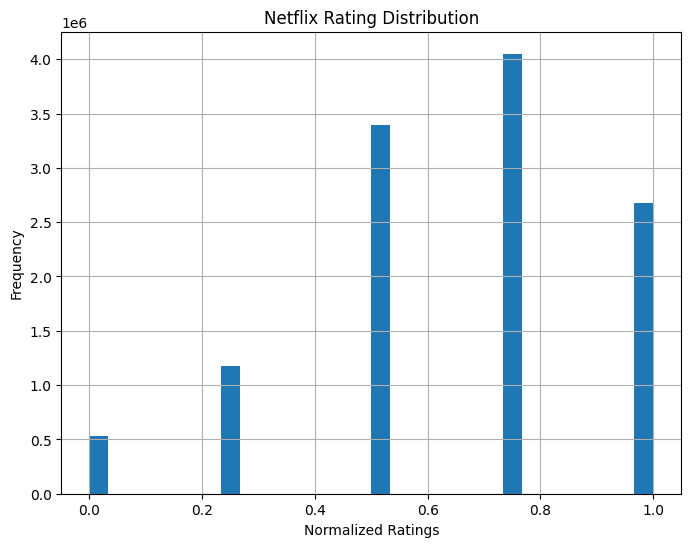

In [234]:

# Dataloaders
batch_size = 128
netflix_train_loader = DataLoader(netflix_train_dataset, batch_size=batch_size, shuffle=True)
netflix_val_loader = DataLoader(netflix_val_dataset, batch_size=batch_size)
netflix_test_loader = DataLoader(netflix_test_dataset, batch_size=batch_size)

# Print loader info
def print_loader_info(loader, name):
    for i, (data, mask) in enumerate(loader):
        if i == 0:
            print(f"{name} - First batch info:")
            print(f"Batch shape: {data.shape}")
            print(f"Batch type: {data.dtype}")
            print(f"Mask shape: {mask.shape}")
            print(f"Mask type: {mask.dtype}")
            print(f"Number of samples in batch: {data.size(0)}")
            break

print_loader_info(netflix_train_loader, "Netflix Train Loader")
print_loader_info(netflix_val_loader, "Netflix Validation Loader")
print_loader_info(netflix_test_loader, "Netflix Test Loader")

# Plot the distribution of the data
plt.figure(figsize=(8, 6))
netflix_ratings_data['rating'].hist(bins=30)
plt.title('Netflix Rating Distribution')
plt.xlabel('Normalized Ratings')
plt.ylabel('Frequency')
plt.show()



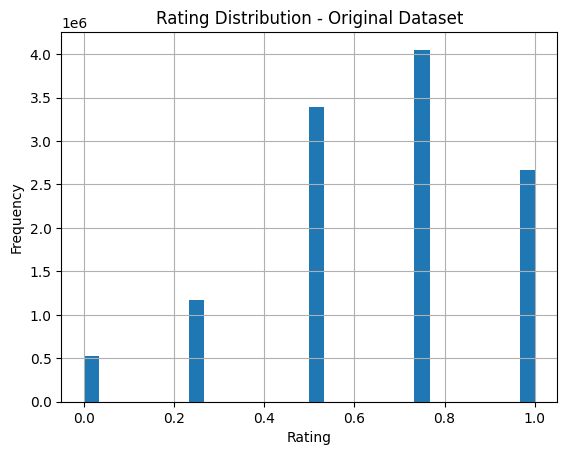

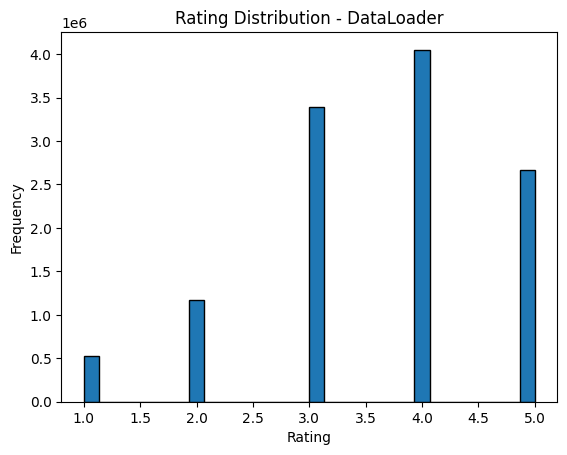

In [236]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Plot the rating distribution from the original dataset
netflix_ratings_data['rating'].hist(bins=30)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Rating Distribution - Original Dataset')
plt.show()

# Function to extract all ratings from the DataLoader
def extract_all_ratings_from_loader(loader):
    all_ratings = []
    for data, mask in loader:
        ratings = data[mask.bool()].numpy()  # Extract ratings where mask is 1
        all_ratings.extend(ratings)
    return np.array(all_ratings)

# Step 2: Extract ratings from all loaders
train_ratings = extract_all_ratings_from_loader(netflix_train_loader)
val_ratings = extract_all_ratings_from_loader(netflix_val_loader)
test_ratings = extract_all_ratings_from_loader(netflix_test_loader)

# Combine all ratings
all_ratings = np.concatenate([train_ratings, val_ratings, test_ratings])

# Denormalize ratings
all_ratings = all_ratings * (netflix_max_rating - netflix_min_rating) + netflix_min_rating

# Plot the rating distribution from the DataLoader
plt.hist(all_ratings, bins=30, edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Rating Distribution - DataLoader')
plt.show()


verify if no data leaks

In [237]:
# Split the data
user_indices = np.arange(netflix_user_item_matrix.shape[0])

# Initial split to separate out the test set
train_val_indices, test_indices = train_test_split(user_indices, test_size=0.2, random_state=42)

# Further split the training and validation sets
train_indices, val_indices = train_test_split(train_val_indices, test_size=0.25, random_state=42)

# Verify no overlap between sets
assert len(set(train_indices) & set(val_indices)) == 0, "Overlap between training and validation sets"
assert len(set(train_indices) & set(test_indices)) == 0, "Overlap between training and test sets"
assert len(set(val_indices) & set(test_indices)) == 0, "Overlap between validation and test sets"

print(f"Training set size: {len(train_indices)}")
print(f"Validation set size: {len(val_indices)}")
print(f"Test set size: {len(test_indices)}")


Training set size: 273248
Validation set size: 91083
Test set size: 91083


In [269]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, num_items, embedding_dim=50):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_items, embedding_dim),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, num_items),
            nn.ReLU(),
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Instantiate the model
num_items = netflix_user_item_matrix.shape[1]
model = Autoencoder(num_items)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Custom Dataset for the user-item matrix
class UserItemDataset(Dataset):
    def __init__(self, user_item_matrix):
        self.user_item_matrix = user_item_matrix

    def __len__(self):
        return self.user_item_matrix.shape[0]

    def __getitem__(self, idx):
        return torch.FloatTensor(self.user_item_matrix[idx].toarray().squeeze())

# Create DataLoader
train_dataset = UserItemDataset(netflix_user_item_matrix[netflix_train_indices])
val_dataset = UserItemDataset(netflix_user_item_matrix[netflix_val_indices])
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)

# Training loop
num_epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer):
    model.train()
    train_losses = []
    val_losses = []
    mae_list = []
    rmse_list = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_idx, (data, genuine_mask, explicit_zero_mask) in enumerate(train_loader):
            data = data.to(device)
            genuine_mask = genuine_mask.to(device)
            explicit_zero_mask = explicit_zero_mask.to(device)

            # Forward pass
            output = model(data)
            loss = criterion(output * genuine_mask, data * genuine_mask)
            epoch_loss += loss.item()

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (batch_idx + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

        avg_train_loss = epoch_loss / len(train_loader)
        val_loss, val_mae, val_rmse = evaluate_model(model, val_loader, criterion)
        
        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        mae_list.append(val_mae)
        rmse_list.append(val_rmse)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}, MAE: {val_mae:.4f}, RMSE: {val_rmse:.4f}")

    return train_losses, val_losses, mae_list, rmse_list

def evaluate_model(model, data_loader, criterion):
    model.eval()
    loss = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, genuine_mask, explicit_zero_mask in data_loader:
            data = data.to(device)
            genuine_mask = genuine_mask.to(device)
            explicit_zero_mask = explicit_zero_mask.to(device)
            output = model(data)
            loss += criterion(output * genuine_mask, data * genuine_mask).item()

            # Collect all non-zero predictions and actual values
            all_preds.append((output * genuine_mask).cpu().numpy())
            all_targets.append((data * genuine_mask).cpu().numpy())

    avg_loss = loss / len(data_loader)
    all_preds = np.concatenate(all_preds).flatten()
    all_targets = np.concatenate(all_targets).flatten()

    # Filter out zero entries for MAE and RMSE calculation
    non_zero_indices = all_targets > 0
    non_zero_preds = all_preds[non_zero_indices]
    non_zero_targets = all_targets[non_zero_indices]

    mae = np.mean(np.abs(non_zero_preds - non_zero_targets))
    rmse = np.sqrt(np.mean((non_zero_preds - non_zero_targets) ** 2))

    return avg_loss, mae, rmse

# Initialize the model, criterion, and optimizer
input_dim = netflix_user_item_matrix.shape[1]
hidden_dims = [512, 256, 128]
latent_dim = 64
learning_rate = 0.001

model = EnhancedAutoencoder(input_dim, hidden_dims, latent_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
num_epochs = 10
train_losses, val_losses, mae_list, rmse_list = train_model(model, netflix_train_loader, netflix_val_loader, num_epochs, criterion, optimizer)

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot MAE and RMSE
plt.figure(figsize=(10, 5))
plt.plot(mae_list, label='MAE')
plt.plot(rmse_list, label='RMSE')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('MAE and RMSE')
plt.legend()
plt.grid(True)
plt.show()


ValueError: not enough values to unpack (expected 3, got 2)

In [251]:
import numpy as np

def get_top_10_recommendations(reconstructed_ratings, movie_titles_df, num_recommendations=10):
    # Sort all movie ratings by their predicted ratings in descending order
    sorted_indices = np.argsort(reconstructed_ratings)[::-1]
    
    # Get the top N movie indices
    top_indices = sorted_indices[:num_recommendations]
    
    # Map factorized movie IDs back to original IDs
    top_movie_ids = [factorized_to_original_movie_id(idx) for idx in top_indices]
    
    # Get movie titles using the original movie IDs
    top_movie_titles = movie_titles_df[movie_titles_df['movieId'].isin(top_movie_ids)]
    
    # Print the top N recommendations
    print("Top Recommendations:")
    for movie_id in top_movie_ids:
        movie_title = top_movie_titles[top_movie_titles['movieId'] == movie_id]['title'].values[0]
        print(f"Movie: {movie_title}, Original Movie ID: {movie_id}, Predicted Rating: {reconstructed_ratings[idx] * (netflix_max_rating - netflix_min_rating) + netflix_min_rating}")
    
    return top_movie_ids

# Assume reconstructed_ratings is the output from the model for the specific user
# Example reconstructed ratings for user with factorized_user_id
reconstructed_ratings = np.random.random(netflix_user_item_matrix.shape[1])  # Replace with the actual reconstructed ratings for the user

# Get movie titles
top_movie_ids = get_top_10_recommendations(reconstructed_ratings, netflix_titles)


Top Recommendations:
Movie: Children of the Corn 666: Isaac's Return, Original Movie ID: 1438, Predicted Rating: 4.70714578037518
Movie: Midsomer Murders: Blue Herrings, Original Movie ID: 1350, Predicted Rating: 4.70714578037518
Movie: Spliced, Original Movie ID: 2211, Predicted Rating: 4.70714578037518
Movie: The Testament of Dr. Mabuse, Original Movie ID: 1838, Predicted Rating: 4.70714578037518
Movie: The White Seal / A Cricket in Times Square, Original Movie ID: 1457, Predicted Rating: 4.70714578037518
Movie: Time Masters, Original Movie ID: 1567, Predicted Rating: 4.70714578037518
Movie: Wodehouse Playhouse: Series 2, Original Movie ID: 2042, Predicted Rating: 4.70714578037518
Movie: Angel of Death, Original Movie ID: 1937, Predicted Rating: 4.70714578037518
Movie: The Marx Brothers in a Nutshell, Original Movie ID: 1437, Predicted Rating: 4.70714578037518
Movie: Orgazmo, Original Movie ID: 1665, Predicted Rating: 4.70714578037518


Epoch [1/20], Batch [100/2135], Loss: 0.0010
Epoch [1/20], Batch [200/2135], Loss: 0.0010
Epoch [1/20], Batch [300/2135], Loss: 0.0009
Epoch [1/20], Batch [400/2135], Loss: 0.0008
Epoch [1/20], Batch [500/2135], Loss: 0.0008
Epoch [1/20], Batch [600/2135], Loss: 0.0006
Epoch [1/20], Batch [700/2135], Loss: 0.0006
Epoch [1/20], Batch [800/2135], Loss: 0.0007
Epoch [1/20], Batch [900/2135], Loss: 0.0006
Epoch [1/20], Batch [1000/2135], Loss: 0.0008
Epoch [1/20], Batch [1100/2135], Loss: 0.0006
Epoch [1/20], Batch [1200/2135], Loss: 0.0007
Epoch [1/20], Batch [1300/2135], Loss: 0.0007
Epoch [1/20], Batch [1400/2135], Loss: 0.0007
Epoch [1/20], Batch [1500/2135], Loss: 0.0006
Epoch [1/20], Batch [1600/2135], Loss: 0.0009
Epoch [1/20], Batch [1700/2135], Loss: 0.0006
Epoch [1/20], Batch [1800/2135], Loss: 0.0006
Epoch [1/20], Batch [1900/2135], Loss: 0.0008
Epoch [1/20], Batch [2000/2135], Loss: 0.0007
Epoch [1/20], Batch [2100/2135], Loss: 0.0007
Epoch 1/20, Train Loss: 0.0008, Validation 

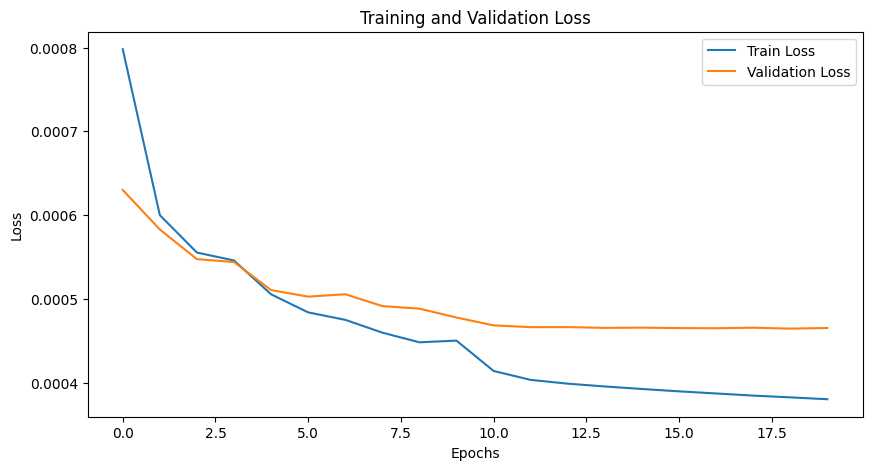

Test MSE Loss: 0.2408
Test Genuine MSE Loss: 0.0000


In [278]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

# Define the Enhanced Autoencoder architecture
class EnhancedAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim, activation_fn=nn.ReLU(), dropout_prob=0.2):
        super(EnhancedAutoencoder, self).__init__()
        
        # Encoder
        encoder_layers = []
        previous_dim = input_dim
        for hidden_dim in hidden_dims:
            encoder_layers.append(nn.Linear(previous_dim, hidden_dim))
            encoder_layers.append(nn.BatchNorm1d(hidden_dim))  # Batch normalization
            encoder_layers.append(activation_fn)
            encoder_layers.append(nn.Dropout(dropout_prob))  # Dropout layer
            previous_dim = hidden_dim
        encoder_layers.append(nn.Linear(previous_dim, latent_dim))  # Latent space layer
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Decoder
        decoder_layers = []
        previous_dim = latent_dim
        for hidden_dim in reversed(hidden_dims):
            decoder_layers.append(nn.Linear(previous_dim, hidden_dim))
            decoder_layers.append(nn.BatchNorm1d(hidden_dim))  # Batch normalization
            decoder_layers.append(activation_fn)
            decoder_layers.append(nn.Dropout(dropout_prob))  # Dropout layer
            previous_dim = hidden_dim
        decoder_layers.append(nn.Linear(previous_dim, input_dim))  # Output layer
        self.decoder = nn.Sequential(*decoder_layers)
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Training and evaluation functions
def train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer, scheduler, device):
    model.train()
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience = 5  # Number of epochs to wait for improvement before early stopping
    patience_counter = 0
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_idx, (data, genuine_mask) in enumerate(train_loader):
            data = data.to(device)
            genuine_mask = genuine_mask.to(device)

            # Forward pass
            output = model(data)
            loss = criterion(output * genuine_mask, data * genuine_mask)
            epoch_loss += loss.item()

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (batch_idx + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

        # Adjust the learning rate
        scheduler.step()

        # Calculate average training loss for the epoch
        train_losses.append(epoch_loss / len(train_loader))

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, genuine_mask in val_loader:
                data = data.to(device)
                genuine_mask = genuine_mask.to(device)

                output = model(data)
                loss = criterion(output * genuine_mask, data * genuine_mask)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return train_losses, val_losses

# Evaluation metric
def evaluate_model(model, test_loader, device):
    model.eval()
    mse_loss = 0
    genuine_mse_loss = 0
    total_genuine_ratings = 0

    with torch.no_grad():
        for data, genuine_mask in test_loader:
            data = data.to(device)
            genuine_mask = genuine_mask.to(device)

            output = model(data)
            mse_loss += F.mse_loss(output, data).item()

            genuine_mse_loss += F.mse_loss(output * genuine_mask, data * genuine_mask).item()
            total_genuine_ratings += genuine_mask.sum().item()

    avg_mse_loss = mse_loss / len(test_loader)
    avg_genuine_mse_loss = genuine_mse_loss / total_genuine_ratings

    print(f"Test MSE Loss: {avg_mse_loss:.4f}")
    print(f"Test Genuine MSE Loss: {avg_genuine_mse_loss:.4f}")

# Load data and create DataLoader instances
# Assuming the data loading and dataset creation steps are done as previously provided

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_dim = max_netflix_movie_id
hidden_dims = [512, 256, 128]
latent_dim = 64
num_epochs = 20
learning_rate = 0.001

# Model, loss function, optimizer, and scheduler
model = EnhancedAutoencoder(input_dim=input_dim, hidden_dims=hidden_dims, latent_dim=latent_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Train the model
train_losses, val_losses = train_model(model, netflix_train_loader, netflix_val_loader, num_epochs, criterion, optimizer, scheduler, device)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the model
evaluate_model(model, netflix_test_loader, device)

      MovieID  OriginalRating  PredictedRating
0           0             1.0         3.766841
1           1             1.0         3.231266
2           2             1.0         3.138326
3           3             1.0         2.430044
4           4             1.0         2.815841
...       ...             ...              ...
2276     2276             1.0         2.233157
2277     2277             1.0         2.358948
2278     2278             1.0         2.875710
2279     2279             1.0         4.031066
2280     2280             1.0         2.527571

[2281 rows x 3 columns]


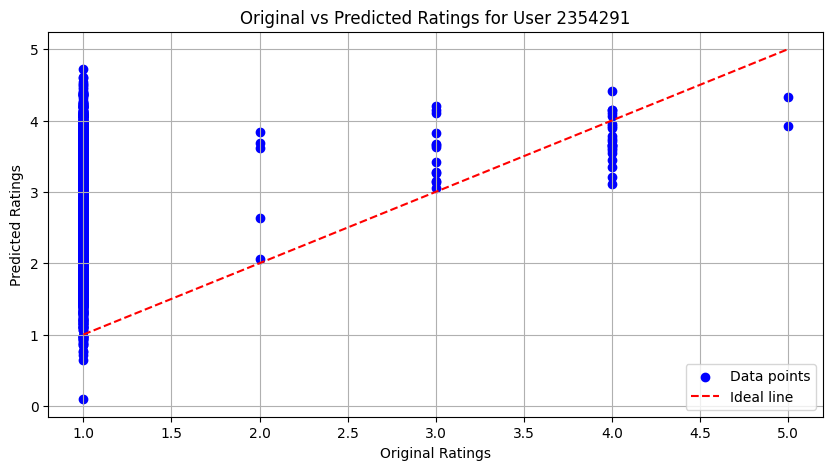

In [280]:
# Function to compare predicted and actual ratings for a specific user
def compare_user_ratings(user_id, model, device):
    model.eval()
    with torch.no_grad():
        user_idx = original_to_factorized_user_id(user_id)
        if user_idx is not None:
            user_data = netflix_user_item_matrix.getrow(user_idx).toarray().flatten()
            user_mask = genuine_ratings_mask.getrow(user_idx).toarray().flatten()
            user_tensor = torch.from_numpy(user_data).float().to(device).unsqueeze(0)
            user_mask_tensor = torch.from_numpy(user_mask).float().to(device).unsqueeze(0)

            user_output = model(user_tensor).cpu().numpy().flatten()
            user_ratings = user_tensor.cpu().numpy().flatten()

            df = pd.DataFrame({
                'MovieID': np.arange(input_dim),
                'OriginalRating': user_ratings * (netflix_max_rating - netflix_min_rating) + netflix_min_rating,
                'PredictedRating': user_output * (netflix_max_rating - netflix_min_rating) + netflix_min_rating
            })
            df = df[df['OriginalRating'] > 0]  # Filter only movies that have actual ratings

            # Print the comparison
            print(df)

            # Plot the comparison
            plt.figure(figsize=(10, 5))
            plt.scatter(df['OriginalRating'], df['PredictedRating'], color='blue', label='Data points')
            plt.plot([df['OriginalRating'].min(), df['OriginalRating'].max()],
                     [df['OriginalRating'].min(), df['OriginalRating'].max()], 'r--', label='Ideal line')
            plt.xlabel('Original Ratings')
            plt.ylabel('Predicted Ratings')
            plt.title(f'Original vs Predicted Ratings for User {user_id}')
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
            print(f"User ID {user_id} not found.")

# Compare predicted and actual ratings for the specific user
compare_user_ratings(specific_user_id, model, device)


In [258]:
import matplotlib.pyplot as plt

# Plotting function
def plot_actual_vs_predicted(comparison_df):
    plt.figure(figsize=(10, 6))
    
    # Plot actual vs predicted ratings
    plt.scatter(comparison_df['actualRating'], comparison_df['predictedRating'], alpha=0.6, color='b', label='Data points')
    
    # Add a line for reference
    plt.plot([1, 5], [1, 5], color='r', linestyle='--', label='Ideal line')
    
    # Labels and title
    plt.xlabel('Actual Ratings')
    plt.ylabel('Predicted Ratings')
    plt.title('Actual vs Predicted Ratings')
    plt.legend()
    plt.grid(True)
    
    # Show plot
    plt.show()

# Assuming `comparison_df` is already created as per previous function
plot_actual_vs_predicted(comparison_df)


KeyError: 'actualRating'

<Figure size 1000x600 with 0 Axes>

defining an autoencoder architecture

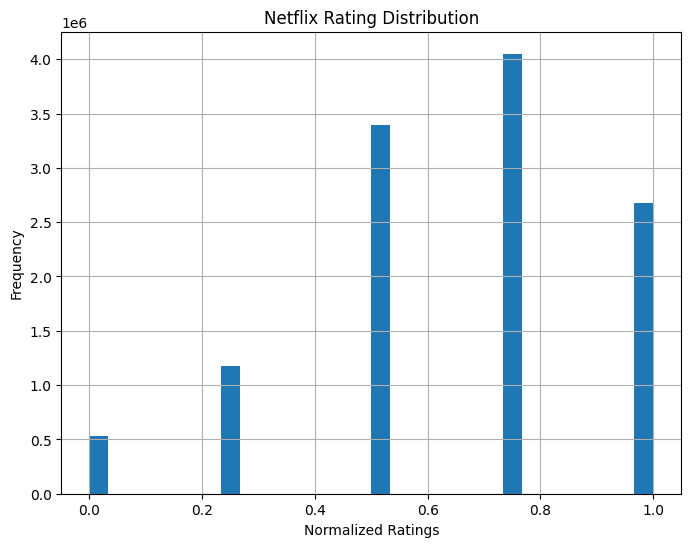

Initial predictions (first batch):
tensor([[ 0.2772,  0.2956,  0.6666,  ...,  0.6241,  0.1987,  0.3144],
        [ 0.3012,  0.3400,  0.6420,  ...,  0.7174,  0.2304,  0.3607],
        [ 0.3013,  0.3014,  0.6702,  ...,  0.6297,  0.2069,  0.3095],
        [-0.1460,  0.2701,  0.5323,  ...,  0.9659,  0.0420,  0.5478],
        [ 0.2771,  0.3092,  0.6569,  ...,  0.6362,  0.2040,  0.3248]])
Actual ratings (first batch):
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Epoch [1/4], Batch [1/2135], Loss: 0.0095
Epoch [1/4], Batch [101/2135], Loss: 0.0008
Epoch [1/4], Batch [201/2135], Loss: 0.0007
Epoch [1/4], Batch [301/2135], Loss: 0.0008
Epoch [1/4], Batch [401/2135], Loss: 0.0008
Epoch [1/4], Batch [501/2135], Loss: 0.0008
Epoch [1/4], Batch [601/2135], Loss: 0.0010
Epoch [1/4], Batch [701/2135], Loss: 0.0010
Epoch [1/4], Batch [801/2135], Lo

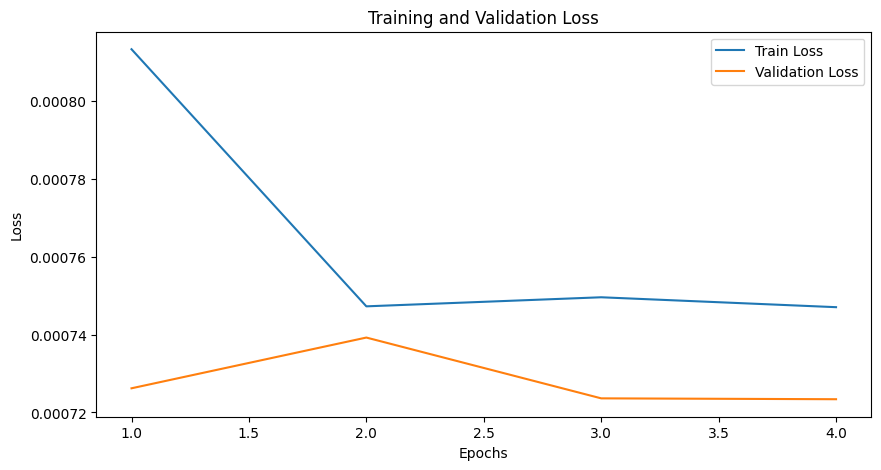

In [268]:
import torch
from torch import nn, optim

class EnhancedAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim, activation_fn=nn.ReLU(), dropout_prob=0.2):
        super(EnhancedAutoencoder, self).__init__()
        
        # Encoder
        encoder_layers = []
        previous_dim = input_dim
        for hidden_dim in hidden_dims:
            encoder_layers.append(nn.Linear(previous_dim, hidden_dim))
            encoder_layers.append(nn.BatchNorm1d(hidden_dim))  # Batch normalization
            encoder_layers.append(activation_fn)
            encoder_layers.append(nn.Dropout(dropout_prob))  # Dropout layer
            previous_dim = hidden_dim
        encoder_layers.append(nn.Linear(previous_dim, latent_dim))  # Latent space layer
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Decoder
        decoder_layers = []
        previous_dim = latent_dim
        for hidden_dim in reversed(hidden_dims):
            decoder_layers.append(nn.Linear(previous_dim, hidden_dim))
            decoder_layers.append(nn.BatchNorm1d(hidden_dim))  # Batch normalization
            decoder_layers.append(activation_fn)
            decoder_layers.append(nn.Dropout(dropout_prob))  # Dropout layer
            previous_dim = hidden_dim
        decoder_layers.append(nn.Linear(previous_dim, input_dim))  # Output layer
        self.decoder = nn.Sequential(*decoder_layers)
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Hyperparameters
input_dim = netflix_user_item_matrix.shape[1]
hidden_dims = [512, 256, 128]
latent_dim = 64
learning_rate = 1e-4
num_epochs = 50

# Model, loss function, optimizer
model = EnhancedAutoencoder(input_dim, hidden_dims, latent_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for batch_idx, (data, mask) in enumerate(netflix_train_loader):
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs * mask, data * mask)  # Apply mask to the loss computation
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(netflix_train_loader)}], Loss: {loss.item():.4f}")

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for data, mask in netflix_val_loader:
            outputs = model(data)
            loss = criterion(outputs * mask, data * mask)
            total_val_loss += loss.item()

    avg_train_loss = total_train_loss / len(netflix_train_loader)
    avg_val_loss = total_val_loss / len(netflix_val_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

# Generate recommendations and comparison function calls...


define two cost functions (for training | for test,validation)

In [239]:
from torch import nn

def custom_loss_function(output, target, model, regularization_strength, use_mse=True):
    """
    Custom loss function for training that includes regularization.
    :param output: The predicted output from the model.
    :param target: The ground truth target values.
    :param model: The model whose parameters are being regularized.
    :param regularization_strength: The strength of the L2 regularization.
    :param use_mse: Whether to use MSE loss. If False, MAE loss will be used.
    :return: The calculated loss value.
    """
    if use_mse:
        reconstruction_loss = nn.MSELoss()(output, target)
    else:
        reconstruction_loss = nn.L1Loss()(output, target)

    l2_penalty = sum(p.pow(2.0).sum() for p in model.parameters())
    loss_with_regularization = reconstruction_loss + regularization_strength * l2_penalty

    return loss_with_regularization


In [240]:
def advanced_masked_loss_function(output, target, mask, model, regularization_strength, use_mse=True):
    if use_mse:
        reconstruction_loss = nn.MSELoss(reduction='none')(output, target)
    else:
        reconstruction_loss = nn.L1Loss(reduction='none')(output, target)

    masked_loss = (reconstruction_loss * mask).sum() / mask.sum()
    l2_penalty = sum(p.pow(2.0).sum() for p in model.parameters())
    loss_with_regularization = masked_loss + regularization_strength * l2_penalty

    return loss_with_regularization


In [241]:
def simple_loss_function(output, target, use_mse=True):
    """
    Simple loss function for evaluation without regularization.
    :param output: The predicted output from the model.
    :param target: The ground truth target values.
    :param use_mse: Whether to use MSE loss. If False, MAE loss will be used.
    :return: The calculated loss value.
    """
    if use_mse:
        loss = nn.MSELoss()(output, target)
    else:
        loss = nn.L1Loss()(output, target)
    return loss


train the model

In [242]:
def train_model_with_adjustments(model, train_loader, val_loader, epochs=50, lr=0.00001, weight_decay=1e-5, regularization_strength=1e-3, use_mse=True):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()  # Ensure dropout and batchnorm are in training mode
        train_loss = 0
        for batch, mask in train_loader:
            optimizer.zero_grad()
            outputs = model(batch)
            loss = advanced_masked_loss_function(outputs, batch, mask, model, regularization_strength, use_mse)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()  # Ensure dropout and batchnorm are in evaluation mode
        val_loss = 0
        with torch.no_grad():
            for batch, mask in val_loader:
                outputs = model(batch)
                loss = advanced_masked_loss_function(outputs, batch, mask, model, 0, use_mse)  # No regularization for validation
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    return train_losses, val_losses

# Adjust hyperparameters and retrain the model
input_dim = 2281  # number of items for movielens/Netflix dataset
hidden_dims = [512, 256]
latent_dim = 128
dropout_prob = 0.5
regularization_strength = 1e-3
epochs = 3
lr = 0.001
weight_decay = 1e-5
use_mse = True

model = EnhancedAutoencoder(input_dim, hidden_dims, latent_dim, dropout_prob=dropout_prob)

# Assuming netflix_train_loader and netflix_val_loader are already defined
train_losses, val_losses = train_model_with_adjustments(model, netflix_train_loader, netflix_val_loader, epochs=epochs, lr=lr, weight_decay=weight_decay, regularization_strength=regularization_strength, use_mse=use_mse)

# Plotting the losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Adjusted Autoencoder Configuration')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/3, Train Loss: 0.5108, Validation Loss: 0.0683


KeyboardInterrupt: 

In [27]:
#train+validation
def train_model(model, train_loader, val_loader, epochs=50, lr=0.001, weight_decay=1e-5, regularization_strength=1e-5, use_mse=True):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            outputs = model(batch)
            #loss = custom_loss_function(outputs, batch, model, regularization_strength, use_mse)
            loss = masked_loss_function(outputs, batch, model, regularization_strength, use_mse)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                outputs = model(batch)
                #loss = custom_loss_function(outputs, batch, model, regularization_strength, use_mse)
                loss = masked_loss_function(outputs, batch, model, 0, use_mse)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    return train_losses, val_losses

Epoch 1/50, Train Loss: 0.8418, Validation Loss: 0.2727
Epoch 2/50, Train Loss: 0.6912, Validation Loss: 0.1305
Epoch 3/50, Train Loss: 0.6066, Validation Loss: 0.0828
Epoch 4/50, Train Loss: 0.5661, Validation Loss: 0.0628
Epoch 5/50, Train Loss: 0.5390, Validation Loss: 0.0551
Epoch 6/50, Train Loss: 0.5253, Validation Loss: 0.0541
Epoch 7/50, Train Loss: 0.5144, Validation Loss: 0.0569
Epoch 8/50, Train Loss: 0.5005, Validation Loss: 0.0523
Epoch 9/50, Train Loss: 0.4878, Validation Loss: 0.0503
Epoch 10/50, Train Loss: 0.4768, Validation Loss: 0.0496
Epoch 11/50, Train Loss: 0.4630, Validation Loss: 0.0478
Epoch 12/50, Train Loss: 0.4567, Validation Loss: 0.0508
Epoch 13/50, Train Loss: 0.4482, Validation Loss: 0.0518
Epoch 14/50, Train Loss: 0.4361, Validation Loss: 0.0513
Epoch 15/50, Train Loss: 0.4277, Validation Loss: 0.0474
Epoch 16/50, Train Loss: 0.4208, Validation Loss: 0.0478
Epoch 17/50, Train Loss: 0.4102, Validation Loss: 0.0514
Epoch 18/50, Train Loss: 0.3991, Validat

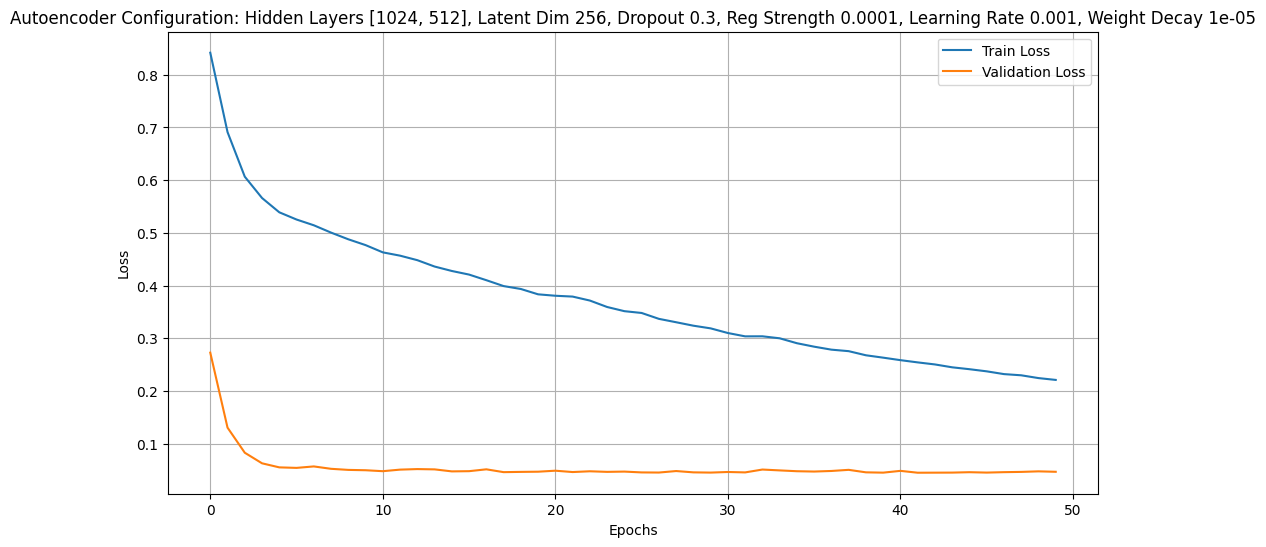

In [28]:
input_dim = 2279  # number of items for movielens/Netflix dataset
hidden_dims = [1024, 512]
latent_dim = 256
dropout_prob = 0.3
regularization_strength = 1e-4
epochs = 50
lr = 0.001
weight_decay = 1e-5
use_mse = True


model = EnhancedAutoencoder(input_dim, hidden_dims, latent_dim, dropout_prob=dropout_prob)

# Assuming netflix_train_loader and netflix_val_loader are already defined
train_losses, val_losses = train_model(model, netflix_train_loader, netflix_val_loader, epochs=epochs, lr=lr, weight_decay=weight_decay, regularization_strength=regularization_strength, use_mse=use_mse)

# Plotting the losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Autoencoder Configuration: Hidden Layers {hidden_dims}, Latent Dim {latent_dim}, Dropout {dropout_prob}, Reg Strength {regularization_strength}, Learning Rate {lr}, Weight Decay {weight_decay}')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/50, Train Loss: 0.1473, Validation Loss: 0.1525
Epoch 1:
 - Training Loss: 0.1473
 - Validation Loss: 0.1525
 - Example outputs: tensor([[0.1190, 0.1160, 0.2460,  ..., 0.1716, 0.1262, 0.1303],
        [0.1525, 0.0746, 0.0699,  ..., 0.2924, 0.0732, 0.0472],
        [0.0784, 0.0730, 0.1375,  ..., 0.2354, 0.0701, 0.0968],
        [0.0369, 0.0517, 0.0321,  ..., 0.1825, 0.0429, 0.0417],
        [0.1634, 0.1831, 0.0523,  ..., 0.5275, 0.1457, 0.1282]])
 - Example targets: tensor([[0.0000, 0.0000, 0.2500,  ..., 0.5000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000]])
Epoch 2/50, Train Loss: 0.1423, Validation Loss: 0.1401
Epoch 3/50, Train Loss: 0.1378, Validation Loss: 0.1347
Epoch 4/50, Train Loss: 0.1331, Validation Loss: 0.1322
Epoch 5/50, Train Loss: 0.1294, V

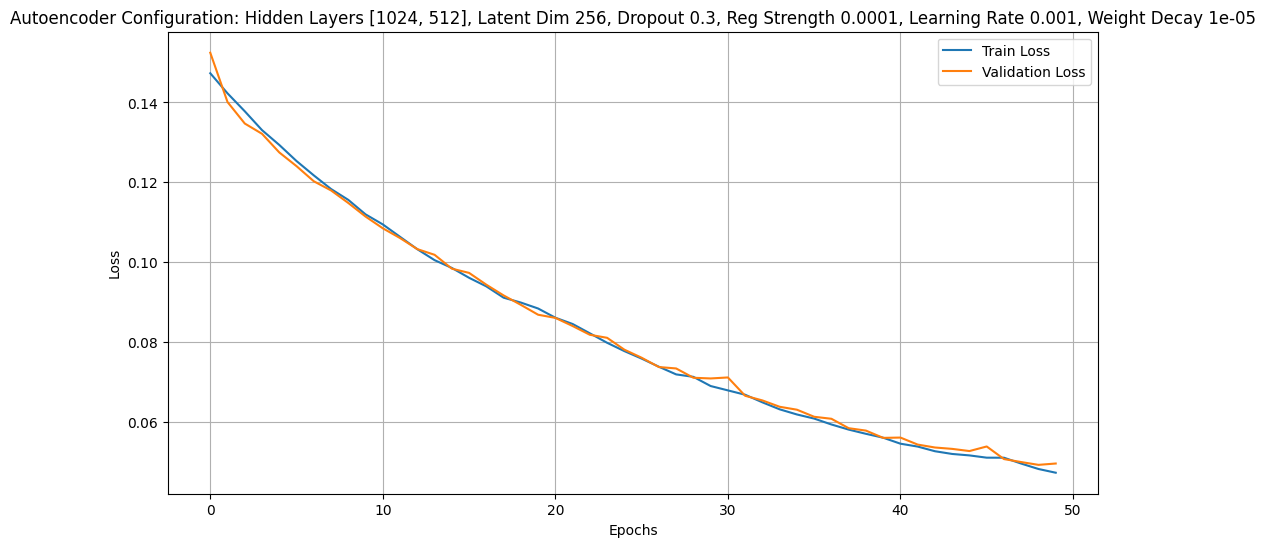

In [19]:
def train_model_debug(model, train_loader, val_loader, epochs=50, lr=0.001, weight_decay=1e-5, regularization_strength=1e-5, use_mse=True):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            outputs = model(batch)
            loss = custom_loss_function(outputs, batch, model, regularization_strength, use_mse)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                outputs = model(batch)
                loss = custom_loss_function(outputs, batch, model, regularization_strength, use_mse)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        # Debugging info
        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch+1}:")
            print(f" - Training Loss: {train_loss:.4f}")
            print(f" - Validation Loss: {val_loss:.4f}")
            print(f" - Example outputs: {outputs[:5]}")
            print(f" - Example targets: {batch[:5]}")

    return train_losses, val_losses

# Train the model with validation and debugging
train_losses, val_losses = train_model_debug(model, netflix_train_loader, netflix_val_loader, epochs=epochs, lr=lr, weight_decay=weight_decay, regularization_strength=regularization_strength, use_mse=use_mse)

# Plotting the losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Autoencoder Configuration: Hidden Layers {hidden_dims}, Latent Dim {latent_dim}, Dropout {dropout_prob}, Reg Strength {regularization_strength}, Learning Rate {lr}, Weight Decay {weight_decay}')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# Combine all data into a single dataset for k-fold cross-validation
netflix_dataset = CSRDataset(netflix_user_item_matrix, np.arange(netflix_user_item_matrix.shape[0]))


from sklearn.model_selection import KFold
def k_fold_cross_validation(model_class, user_item_matrix, input_dim, hidden_dims, latent_dim, dropout_prob, regularization_params, k=5, epochs=50, lr=0.001, weight_decay=1e-5, use_mse=True):
    indices = np.arange(user_item_matrix.shape[0])
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    best_reg_strength = None
    best_avg_val_loss = float('inf')
    all_results = []

    for reg_strength in regularization_params:
        print(f"Evaluating regularization strength: {reg_strength}")
        fold_train_losses = []
        fold_val_losses = []
        avg_val_losses = []

        for fold, (train_indices, val_indices) in enumerate(kf.split(indices)):
            print(f"Fold {fold+1}/{k}")
            
            # Create DataLoaders for the current fold
            train_subset = CSRDataset(user_item_matrix, train_indices)
            val_subset = CSRDataset(user_item_matrix, val_indices)
            train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=64)

            # Initialize the model
            model = model_class(input_dim, hidden_dims, latent_dim, dropout_prob=dropout_prob)

            # Train the model
            train_losses, val_losses = train_model(model, train_loader, val_loader, epochs=epochs, lr=lr, weight_decay=weight_decay, regularization_strength=reg_strength, use_mse=use_mse)
            
            # Store the training and validation losses for each fold
            fold_train_losses.append(train_losses)
            fold_val_losses.append(val_losses)

            # Store the average validation loss for this fold
            avg_val_losses.append(val_losses[-1])

        avg_val_loss = np.mean(avg_val_losses)
        all_results.append((reg_strength, avg_val_loss, fold_train_losses, fold_val_losses))

        if avg_val_loss < best_avg_val_loss:
            best_avg_val_loss = avg_val_loss
            best_reg_strength = reg_strength
    
    print(f"Best regularization strength: {best_reg_strength}, Average Validation Loss: {best_avg_val_loss:.4f}")
    
    return best_reg_strength, all_results




In [81]:
regularization_params = [1e-5, 1e-4, 1e-3, 1e-2]

# Combine all data into a single dataset for k-fold cross-validation
netflix_dataset = CSRDataset(netflix_user_item_matrix, np.arange(netflix_user_item_matrix.shape[0]))

best_reg_strength, all_results = k_fold_cross_validation(
    EnhancedAutoencoder, netflix_user_item_matrix, input_dim, hidden_dims, latent_dim, dropout_prob,
    regularization_params, k=3, epochs=epochs, lr=lr, weight_decay=weight_decay, use_mse=use_mse
)


Evaluating regularization strength: 1e-05
Fold 1/3
Epoch 1/50, Train Loss: 0.2619, Validation Loss: 0.1080
Epoch 2/50, Train Loss: 0.1389, Validation Loss: 0.1598
Epoch 3/50, Train Loss: 0.1101, Validation Loss: 0.1229
Epoch 4/50, Train Loss: 0.1013, Validation Loss: 0.1019
Epoch 5/50, Train Loss: 0.1018, Validation Loss: 0.0966
Epoch 6/50, Train Loss: 0.0963, Validation Loss: 0.0905
Epoch 7/50, Train Loss: 0.0955, Validation Loss: 0.0901
Epoch 8/50, Train Loss: 0.0964, Validation Loss: 0.0880
Epoch 9/50, Train Loss: 0.0940, Validation Loss: 0.0873
Epoch 10/50, Train Loss: 0.0919, Validation Loss: 0.0884
Epoch 11/50, Train Loss: 0.0906, Validation Loss: 0.0859
Epoch 12/50, Train Loss: 0.0893, Validation Loss: 0.0849
Epoch 13/50, Train Loss: 0.0876, Validation Loss: 0.0849
Epoch 14/50, Train Loss: 0.0856, Validation Loss: 0.0828
Epoch 15/50, Train Loss: 0.0848, Validation Loss: 0.0811
Epoch 16/50, Train Loss: 0.0841, Validation Loss: 0.0806
Epoch 17/50, Train Loss: 0.0831, Validation Lo

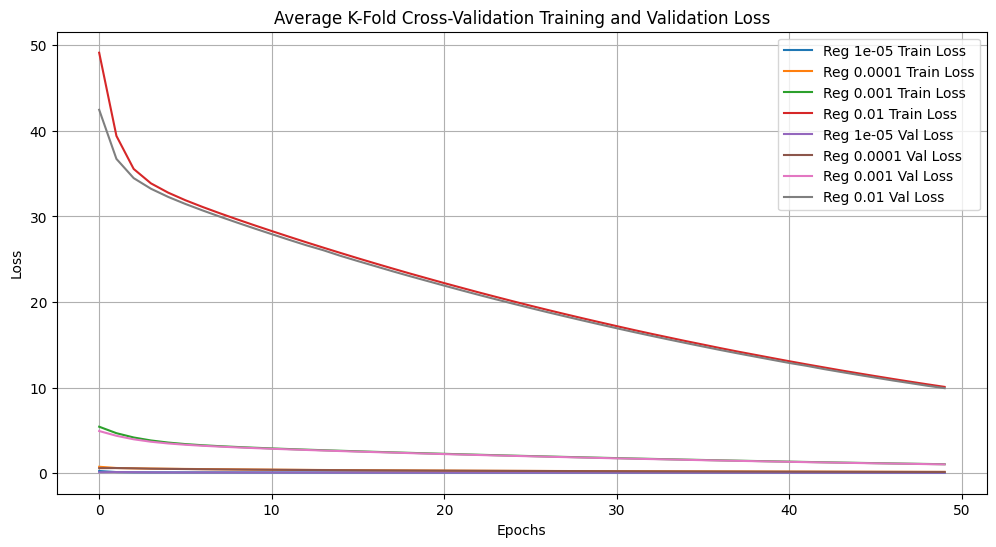

In [84]:
import numpy as np
import matplotlib.pyplot as plt

def average_losses_per_fold(fold_losses):
    """Compute average losses per epoch across folds."""
    # Ensure the fold losses are the same length
    num_epochs = len(fold_losses[0])
    avg_losses = np.zeros(num_epochs)

    for fold_loss in fold_losses:
        avg_losses += np.array(fold_loss)

    avg_losses /= len(fold_losses)
    return avg_losses

# Average the losses per fold
avg_train_losses_per_reg = []
avg_val_losses_per_reg = []

for reg_strength, avg_val_loss, fold_train_losses, fold_val_losses in all_results:
    avg_train_loss = average_losses_per_fold(fold_train_losses)
    avg_val_loss = average_losses_per_fold(fold_val_losses)
    avg_train_losses_per_reg.append((reg_strength, avg_train_loss))
    avg_val_losses_per_reg.append((reg_strength, avg_val_loss))

# Plot the averaged losses
plt.figure(figsize=(12, 6))
for reg_strength, avg_train_loss in avg_train_losses_per_reg:
    plt.plot(avg_train_loss, label=f'Reg {reg_strength} Train Loss')
for reg_strength, avg_val_loss in avg_val_losses_per_reg:
    plt.plot(avg_val_loss, label=f'Reg {reg_strength} Val Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Average K-Fold Cross-Validation Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


we now train the model with the best regularization strength and evaluate on the final test set

Epoch 1/30, Train Loss: 0.3600, Validation Loss: 0.2067
Epoch 2/30, Train Loss: 0.2051, Validation Loss: 0.0743
Epoch 3/30, Train Loss: 0.1494, Validation Loss: 0.0569
Epoch 4/30, Train Loss: 0.1345, Validation Loss: 0.0492
Epoch 5/30, Train Loss: 0.1284, Validation Loss: 0.0479
Epoch 6/30, Train Loss: 0.1218, Validation Loss: 0.0481
Epoch 7/30, Train Loss: 0.1165, Validation Loss: 0.0468
Epoch 8/30, Train Loss: 0.1148, Validation Loss: 0.0416
Epoch 9/30, Train Loss: 0.1086, Validation Loss: 0.0417
Epoch 10/30, Train Loss: 0.1066, Validation Loss: 0.0392
Epoch 11/30, Train Loss: 0.1085, Validation Loss: 0.0427
Epoch 12/30, Train Loss: 0.1065, Validation Loss: 0.0423
Epoch 13/30, Train Loss: 0.1046, Validation Loss: 0.0431
Epoch 14/30, Train Loss: 0.1029, Validation Loss: 0.0385
Epoch 15/30, Train Loss: 0.0998, Validation Loss: 0.0409
Epoch 16/30, Train Loss: 0.0995, Validation Loss: 0.0440
Epoch 17/30, Train Loss: 0.1010, Validation Loss: 0.0385
Epoch 18/30, Train Loss: 0.0984, Validat

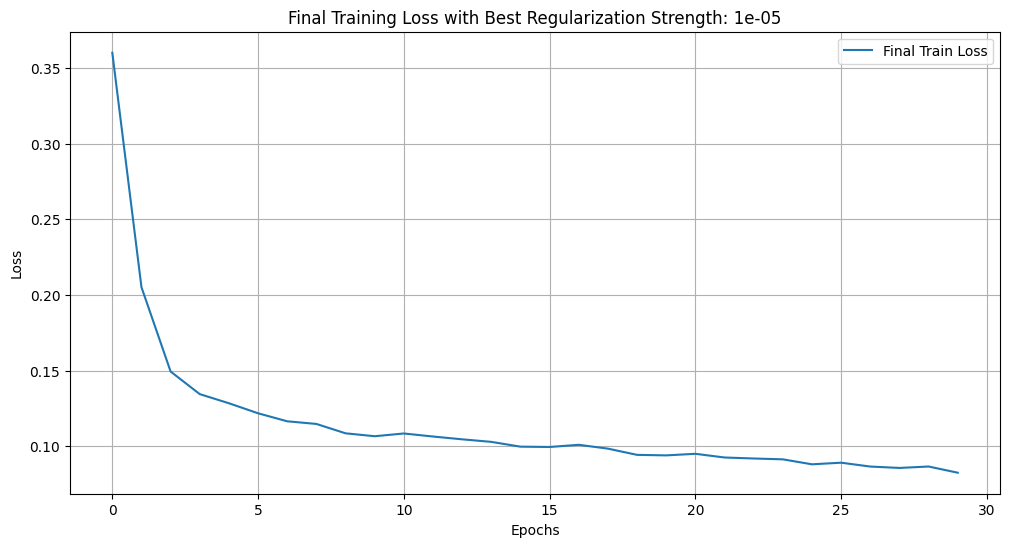

In [29]:
# Combine the training and validation indices to create a full training dataset
best_reg_strength=1e-5
full_train_indices = np.concatenate((netflix_train_indices, netflix_val_indices))

# Create the full training dataset and loader
netflix_full_train_dataset = CSRDataset(netflix_user_item_matrix, full_train_indices)
netflix_full_train_loader = DataLoader(netflix_full_train_dataset, batch_size=batch_size, shuffle=True)

# Initialize the model with the best regularization strength found from cross-validation
best_model = EnhancedAutoencoder(input_dim, hidden_dims, latent_dim, dropout_prob=dropout_prob)

# Train the best model on the full training dataset
final_train_losses, _ = train_model(best_model, netflix_full_train_loader, netflix_val_loader, epochs=30, lr=lr, weight_decay=weight_decay, regularization_strength=best_reg_strength, use_mse=use_mse)

# Plotting the final training losses
plt.figure(figsize=(12, 6))
plt.plot(final_train_losses, label='Final Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Final Training Loss with Best Regularization Strength: {best_reg_strength}')
plt.legend()
plt.grid(True)
plt.show()


feature to visualize personalized recommendations: for a given user ID, print their top rated movies and then print top recommendations

In [30]:
def get_user_ratings(user_id, ratings_data):
    """Retrieve all ratings for a given user."""
    return ratings_data[ratings_data['userId'] == user_id]

def generate_predictions(model, user_id, user_item_matrix):
    """Generate movie rating predictions for a given user, including already rated movies."""
    # Get the user's current ratings
    user_ratings = user_item_matrix[user_id].toarray().flatten()
    
    # Convert to tensor and get model predictions
    user_tensor = torch.FloatTensor(user_ratings).unsqueeze(0)
    model.eval()
    with torch.no_grad():
        reconstructed_vector = model(user_tensor).squeeze(0).numpy()
    
    return reconstructed_vector

# Example usage to generate and compare predictions for a random user
random_user_id = np.random.choice(netflix_train_indices)
predicted_ratings = generate_predictions(best_model, random_user_id, netflix_user_item_matrix)

# Display actual and predicted ratings for movies the user has rated
user_actual_ratings = get_user_ratings(random_user_id, netflix_ratings_data)
print(f"Actual vs Predicted Ratings for User ID {random_user_id}:")

comparison = []
for _, row in user_actual_ratings.iterrows():
    movie_id = row['movieId']
    if movie_id < len(predicted_ratings):  # Ensure the movie_id is within bounds
        actual_rating = row['rating']  # Use the normalized rating directly
        predicted_rating = predicted_ratings[int(movie_id)]  # Ensure movie_id is an integer
        title = netflix_titles.iloc[int(movie_id)]['title'] if movie_id < len(netflix_titles) else 'Unknown'
        comparison.append((title, actual_rating, predicted_rating))

# Sort comparison by actual rating
comparison.sort(key=lambda x: x[1], reverse=True)

# Print the comparison
for title, actual, predicted in comparison:
    print(f"{title}: Actual Rating: {actual:.2f}, Predicted Rating: {predicted:.2f}")


Actual vs Predicted Ratings for User ID 194:
The Bad and the Beautiful: Actual Rating: 1.00, Predicted Rating: 0.45
Justice League: Actual Rating: 1.00, Predicted Rating: 0.57
Dragonheart: Actual Rating: 1.00, Predicted Rating: 0.64
Davy Crockett: 50th Anniversary Double Feature: Actual Rating: 1.00, Predicted Rating: 0.63
I Love Lucy: Season 2: Actual Rating: 1.00, Predicted Rating: 0.64
Star Trek: Voyager: Season 1: Actual Rating: 1.00, Predicted Rating: 0.78
X2: X-Men United: Actual Rating: 1.00, Predicted Rating: 0.79
Star Trek: Deep Space Nine: Season 5: Actual Rating: 1.00, Predicted Rating: 0.67
The Pacifier: Actual Rating: 1.00, Predicted Rating: 0.71
Star Trek: Voyager: Season 5: Actual Rating: 1.00, Predicted Rating: 0.71
The 10th Kingdom: Actual Rating: 1.00, Predicted Rating: 0.68
Recess: School's Out: Actual Rating: 1.00, Predicted Rating: 0.44
Building the Great Pyramid: Actual Rating: 1.00, Predicted Rating: 0.72
Jimmy Neutron: Boy Genius: Actual Rating: 1.00, Predicted 

Is the data meaningful?
---
1. will the algorithm make better predictions if 
    a) the user has given more reviews
    b) the movies that are recommended to him have received more reviews

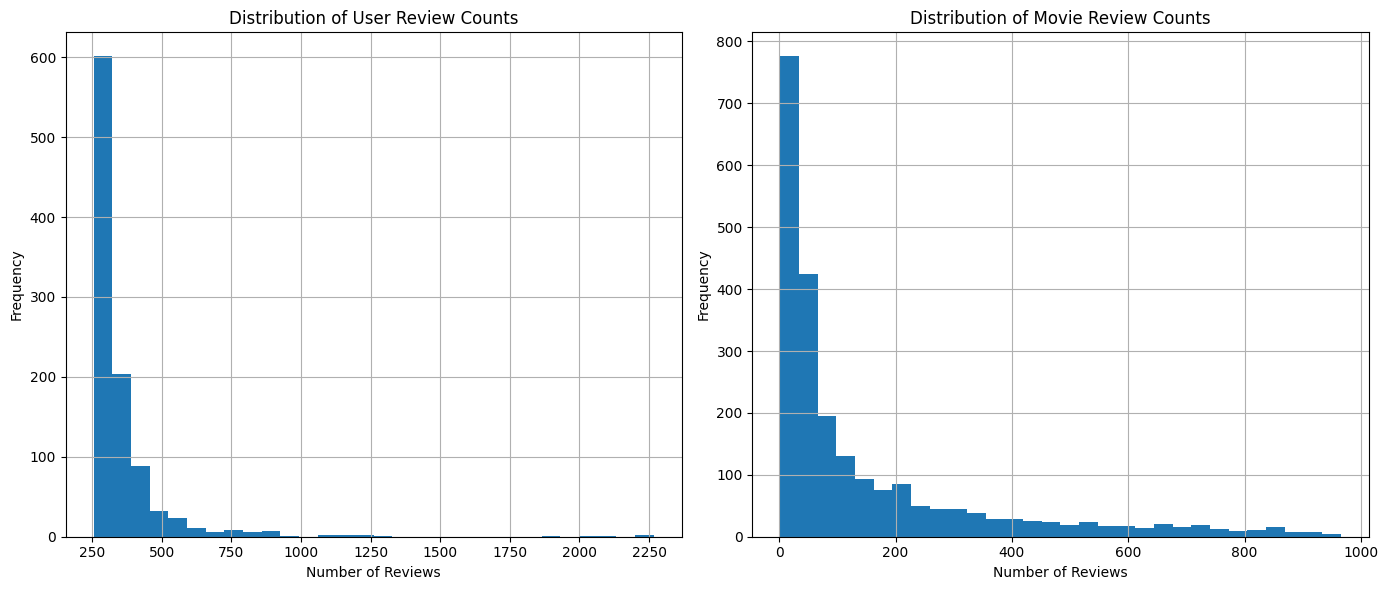

In [31]:
import matplotlib.pyplot as plt

def count_user_reviews(ratings_data):
    """
    Count the number of reviews each user has made.
    :param ratings_data: DataFrame containing user ratings.
    :return: Series with the count of reviews for each user.
    """
    user_review_counts = ratings_data['userId'].value_counts()
    return user_review_counts

def count_movie_reviews(ratings_data):
    """
    Count the number of reviews each movie has received.
    :param ratings_data: DataFrame containing user ratings.
    :return: Series with the count of reviews for each movie.
    """
    movie_review_counts = ratings_data['movieId'].value_counts()
    return movie_review_counts



# Example usage
user_review_counts = count_user_reviews(netflix_ratings_data)
movie_review_counts = count_movie_reviews(netflix_ratings_data)

def plot_review_counts(user_review_counts, movie_review_counts):
    """
    Plot the distribution of user and movie review counts.
    :param user_review_counts: Series with the count of reviews for each user.
    :param movie_review_counts: Series with the count of reviews for each movie.
    """
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    user_review_counts.hist(bins=30)
    plt.title('Distribution of User Review Counts')
    plt.xlabel('Number of Reviews')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    movie_review_counts.hist(bins=30)
    plt.title('Distribution of Movie Review Counts')
    plt.xlabel('Number of Reviews')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Example usage
plot_review_counts(user_review_counts, movie_review_counts)



In [32]:
def evaluate_user_predictions(user_id, model, user_item_matrix, ratings_data, movies_data, top_n=10):
    user_vector = user_item_matrix[user_id].toarray().squeeze(0)
    user_vector_tensor = torch.from_numpy(user_vector).float().unsqueeze(0)
    
    model.eval()
    with torch.no_grad():
        reconstructed_vector = model(user_vector_tensor).squeeze(0).numpy()
    
    user_actual_ratings = ratings_data[ratings_data['userId'] == user_id]
    comparison = []

    for _, row in user_actual_ratings.iterrows():
        movie_id = row['movieId']
        if movie_id < len(reconstructed_vector):
            actual_rating = row['rating']
            predicted_rating = reconstructed_vector[int(movie_id)]
            title = movies_data.iloc[int(movie_id)]['title'] if movie_id < len(movies_data) else 'Unknown'
            comparison.append((title, actual_rating, predicted_rating))

    comparison.sort(key=lambda x: x[1], reverse=True)
    print(f"Actual vs Predicted Ratings for User ID {user_id}:")
    for title, actual, predicted in comparison:
        print(f"{title}: Actual Rating: {actual:.2f}, Predicted Rating: {predicted:.2f}")

# Example usage
random_user_id = np.random.choice(netflix_train_indices)
evaluate_user_predictions(random_user_id, model, netflix_user_item_matrix, netflix_ratings_data, netflix_titles, top_n=10)


Actual vs Predicted Ratings for User ID 21:
Immortal Beloved: Actual Rating: 1.00, Predicted Rating: 0.58
Dragonheart: Actual Rating: 1.00, Predicted Rating: 0.73
I Love Lucy: Season 2: Actual Rating: 1.00, Predicted Rating: 0.90
Congo: Actual Rating: 1.00, Predicted Rating: 0.60
The Great Race: Actual Rating: 1.00, Predicted Rating: 0.71
Star Trek: Voyager: Season 1: Actual Rating: 1.00, Predicted Rating: 0.73
The Strongest Man in the World: Actual Rating: 1.00, Predicted Rating: 0.71
Funny Face: Actual Rating: 1.00, Predicted Rating: 0.62
Woman of the Year: Actual Rating: 1.00, Predicted Rating: 0.80
Herbie Rides Again: Actual Rating: 1.00, Predicted Rating: 0.57
Sex and the City: Season 4: Actual Rating: 1.00, Predicted Rating: 0.72
High Fidelity: Actual Rating: 1.00, Predicted Rating: 0.52
The Pacifier: Actual Rating: 1.00, Predicted Rating: 0.84
Princess Caraboo: Actual Rating: 1.00, Predicted Rating: 0.61
20,000 Leagues Under the Sea: Actual Rating: 1.00, Predicted Rating: 0.74
R

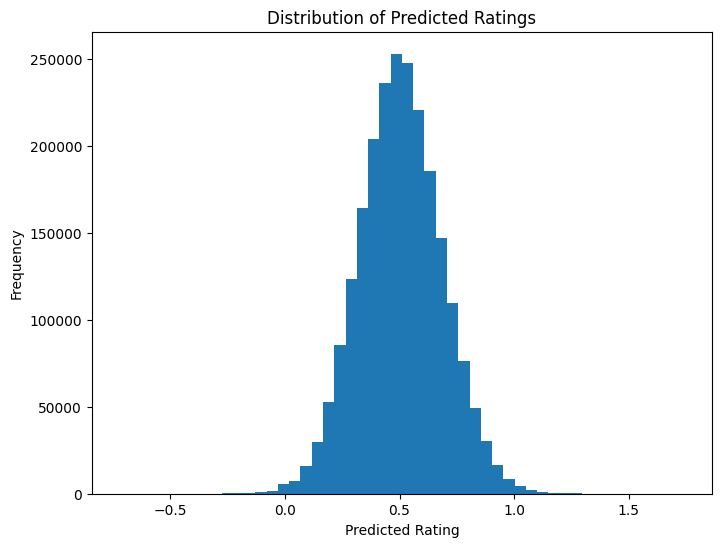

In [33]:
def analyze_predictions_distribution(model, user_item_matrix, top_n=10):
    all_predictions = []

    for user_id in range(user_item_matrix.shape[0]):
        user_vector = user_item_matrix[user_id].toarray().squeeze(0)
        user_vector_tensor = torch.from_numpy(user_vector).float().unsqueeze(0)

        model.eval()
        with torch.no_grad():
            reconstructed_vector = model(user_vector_tensor).squeeze(0).numpy()
        
        all_predictions.extend(reconstructed_vector)
    
    plt.figure(figsize=(8, 6))
    plt.hist(all_predictions, bins=50)
    plt.title('Distribution of Predicted Ratings')
    plt.xlabel('Predicted Rating')
    plt.ylabel('Frequency')
    plt.show()

# Example usage
analyze_predictions_distribution(best_model, netflix_user_item_matrix)
